In [1]:
# My code
import neuraltda.simpComp as sc
import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
from ephys import rasters
import pycuslsa as pyslsa

# System Libs
from importlib import reload
import pickle
import glob
import os

# Scientific Libs
import numpy as np
from scipy.optimize import brentq
import tqdm

# Plotting libs
import matplotlib.pyplot as plt
import seaborn as sns

# Set some parameters
sns.set_context('poster')
sns.set_style('white')
%matplotlib inline
reload(sa)
reload(sc)
reload(pyslsa)


/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'pycuslsa' from '/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/pycuslsa.cpython-36m-x86_64-linux-gnu.so'>

In [21]:
nsamples2 = 10
d = 1

def poisson_model_loss_generic(a, beta, E_data, ncells, nwin, n_samples, metric_func):
    # take a probabilities,
    # generate random configurations, 
    # measure KL divergence to data, 
    # report loss
    
    # Declare variables
    KLsave = []
    JSsave = []
    probs = (a*np.ones((ncells, 1)))

    # Generate new spike trains
    samples = np.random.rand(ncells, nwin, n_samples)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, n_samples))
    binMatsamples = np.greater(probmat, samples).astype(int)
    
    # Compute simplicial complex 
    SCGs = []
    for ind in range(n_samples):
        
        # Compute SCG for test spike trains
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        E_model = sc.simplicialChainGroups(msimps)

        # Compute Laplacians for target and tests
        Lsamp = sc.compute_laplacian(E_model, d)
        Ldata = sc.compute_laplacian(E_data, d)
        
        # Reconcile Laplacian dimensions
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
            
        # Compute KL divergence for this test spike train and store it. 
        KLsave.append(metric_func(Ldata, Lsamp, beta))
    
    # Compute mean and stderr over all the test spike trains
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(n_samples)
    return (m, stderr)


def loss_new(a, beta):
    # take a probabilities,
    # generate random configurations, 
    # measure KL divergence to data, 
    # report loss
    
    # Declare variables
    KLsave = []
    JSsave = []
    probs = (a*np.ones((ncells, 1)))

    # Generate new spike trains
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    
    # Compute simplicial complex 
    SCGs = []
    for ind in range(nsamples2):
        
        # Compute SCG for test spike trains
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        # Compute Laplacians for target and tests
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        
        # Reconcile Laplacian dimensions
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
            
        # Compute density matrices
        rsamp = sc.densityMatrix(Lsamp, beta)
        rdata = sc.densityMatrix(Ldata, beta)
        
        # Compute KL divergence for this test spike train and store it. 
        KLsave.append(sc.KLdivergence(rdata, rsamp))
    
    # Compute mean and stderr over all the test spike trains
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

def loss_new_lap(a, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    JSsave = []
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        #Ddata = sc.boundaryOperatorMatrix(Edata, d)
        #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
        #rsamp = sc.densityMatrix(Lsamp, beta)
        
        #rdata = sc.densityMatrix(Ldata, beta)
        #print(Ldata)
        #print(rsamp)
        #print(rdata)
        
        #KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
        #JSsave.append(sc.JSdivergence(rdata, rsamp))
        KLsave.append(sc.KLdivergence_lap(Ldata, Lsamp, beta))
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

def loss_new_likelihood(a, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    JSsave = []
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        #Ddata = sc.boundaryOperatorMatrix(Edata, d)
        #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        #print(Ldata)
        #print(rsamp)
        #print(rdata)
        
        #KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
        #JSsave.append(sc.JSdivergence(rdata, rsamp))
        KLsave.append(sc.Likelihood(rdata, rsamp))
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

def loss_new_JS(a, beta):
    #Calculate JS according to Biam Dedom, using entropy
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    JSsave = []
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        #Ddata = sc.boundaryOperatorMatrix(Edata, d)
        #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        #print(Ldata)
        #print(rsamp)
        #print(rdata)
        
        #KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
        JSsave.append(sc.JSdivergence(rdata, rsamp))
        KLsave.append(sc.KLdivergence(rdata, rsamp))
    m = np.mean(KLsave)
    mJS = np.mean(JSsave)
    std = np.std(KLsave)
    stdJS = np.std(JSsave)
    stderr = std / np.sqrt(nsamples2)
    stderrJS = stdJS / np.sqrt(nsamples2)
    return (m, mJS, stderr, stderrJS)

def loss_new_KLmatlog(a, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    JSsave = []
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        #Ddata = sc.boundaryOperatorMatrix(Edata, d)
        #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        #print(Ldata)
        #print(rsamp)
        #print(rdata)
        
        KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
        #JSsave.append(sc.JSdivergence(rdata, rsamp))
        #KLsave.append(sc.KLdivergence(rdata, rsamp))
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

def loss_old_JS(a, beta):
    #Calculate JS according to Biam Dedom, using entropy
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    JSsave = []
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        #Ddata = sc.boundaryOperatorMatrix(Edata, d)
        #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        #print(Ldata)
        #print(rsamp)
        #print(rdata)
        
        #KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
        JSsave.append(sc.JSdivergence_old(rdata, rsamp))
        #KLsave.append(sc.KLdivergence(rdata, rsamp))
    #m = np.mean(KLsave)
    mJS = np.mean(JSsave)
    #std = np.std(KLsave)
    stdJS = np.std(JSsave)
    #stderr = std / np.sqrt(nsamples2)
    m=0
    stderr=0
    stderrJS = stdJS / np.sqrt(nsamples2)
    return (m, mJS, stderr, stderrJS)

In [22]:
# Generate binary matrix with given probabilities for each "cell"
ncells = 20
nwin = 1000
a = 0.02
probs = (a*np.ones((ncells, 1)))
nsamples = 1
samples = np.random.rand(ncells, nwin, nsamples)
probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
probmat = np.tile(probmat, (1, 1, nsamples))
binMatsamples = np.greater(probmat, samples).astype(int)

# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


est_save = []
ntrials = 1
X = np.linspace(0.0005, 0.08, 100)

beta = -0.15

for t in range(ntrials):
    #print(t)
    KL=[]
    JS = []
    KLerr = []
    JSerr = []
    for x in tqdm.tqdm(X):
        #print(x)
        (m, stderr) = loss_new_lap(x, beta)
        KL.append(m)
        KLerr.append(stderr)
        
    
    index_min = np.argmin(KL)
    est_save.append(X[index_min])

  0%|          | 0/100 [00:00<?, ?it/s]

error1
error2


  4%|▍         | 4/100 [00:00<00:22,  4.33it/s]

error1
error2
error1
error2
error1
error2
error1
error2
error1
error2
error1
error2
error1
error2
error1
error2
error1
error2
error2
error2
error1
error2
error1
error2
error1
error2
error1
error2
error1
error2
error1
error2
error2
error1
error2
error1
error2
error2
error1
error2
error1
error2
error1
error2
error2
error1
error2
error2
error2
error1
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error1
error2
error1
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2


 10%|█         | 10/100 [00:00<00:12,  7.47it/s]

error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2


 12%|█▏        | 12/100 [00:00<00:09,  9.11it/s]

error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2


 19%|█▉        | 19/100 [00:01<00:05, 14.08it/s]

error2
error2
error2
error2
error2


100%|██████████| 100/100 [00:27<00:00,  1.60it/s]


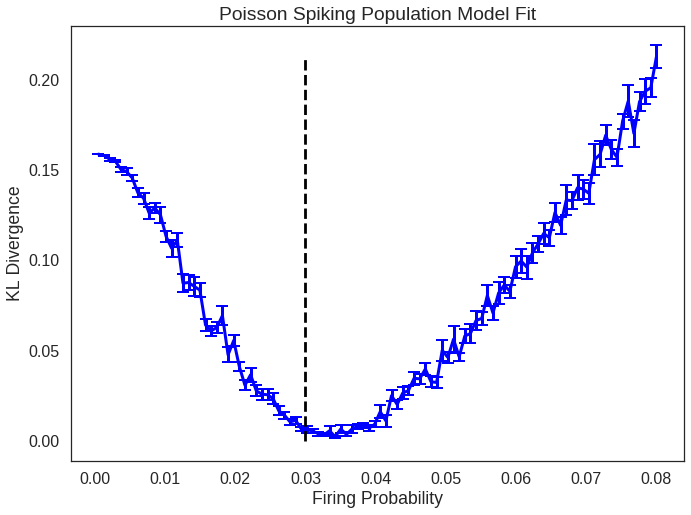

In [4]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
#plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0,np.amax(KL), 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('KL Divergence')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

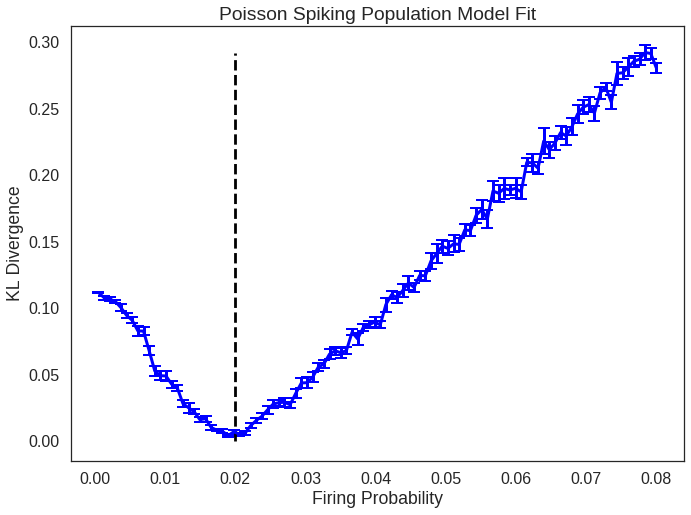

In [9]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')

plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(KL), 20), 'k--')
#plt.xlim([0, 0.04])
#plt.ylim(0, 0.75)
plt.xlabel('Firing Probability')
plt.ylabel('KL Divergence')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

In [178]:
np.mean(np.sum(binMatsamples[:, :, 0], axis=1) / nwin)

0.020300000000000006

In [88]:
# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


est_save = []
ntrials = 1
X = np.linspace(0.005, 0.06, 20)

beta = -1.

#likelihood

for t in range(ntrials):
    print(t)
    KL=[]
    JS = []
    KLerr = []
    JSerr = []
    for x in X:
        print(x)
        (m, stderr) = loss_new_likelihood(x, beta)
        KL.append(m)
        KLerr.append(stderr)
        
    
    index_min = np.argmin(KL)
    est_save.append(X[index_min])

0
0.005
error2
error2
error2
error2
error2
0.00789473684211
error2
error2
error2
0.0107894736842
error2
error2
0.0136842105263
0.0165789473684
0.0194736842105
0.0223684210526
0.0252631578947
0.0281578947368
0.0310526315789
0.0339473684211
0.0368421052632
0.0397368421053
0.0426315789474
0.0455263157895
0.0484210526316
0.0513157894737
0.0542105263158
0.0571052631579
0.06


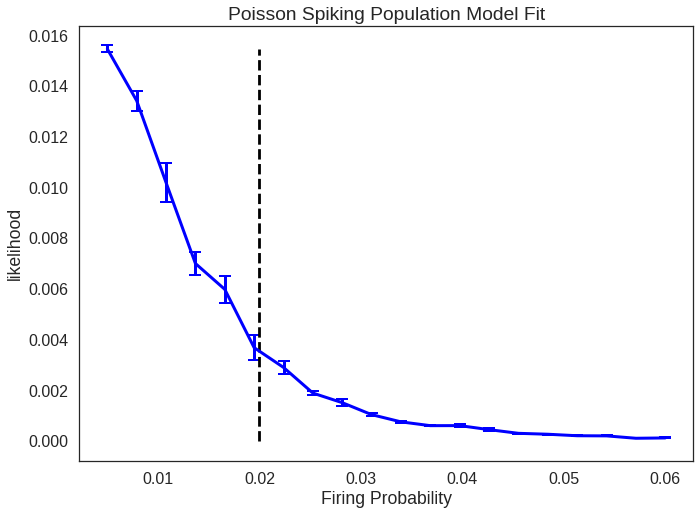

In [89]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
#plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(KL), 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('likelihood')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

In [90]:
# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


est_save = []
ntrials = 1
X = np.linspace(0.005, 0.05, 20)

beta = -1

for t in range(ntrials):
    print(t)
    KL=[]
    JS = []
    KLerr = []
    JSerr = []
    for x in X:
        print(x)
        (m, mjs, stderr, stderrjs) = loss_new_JS(x, beta)
        KL.append(m)
        JS.append(mjs)
        KLerr.append(stderr)
        JSerr.append(stderrjs)
        
    
    index_min = np.argmin(KL)
    est_save.append(X[index_min])

0
0.005
error2
error2
error2
error2
error2
0.00736842105263
error2
error2
error2
0.00973684210526
error2
error2
0.0121052631579
0.0144736842105
0.0168421052632
0.0192105263158
0.0215789473684
0.0239473684211
0.0263157894737
0.0286842105263
0.0310526315789
0.0334210526316
0.0357894736842
0.0381578947368
0.0405263157895
0.0428947368421
0.0452631578947
0.0476315789474
0.05


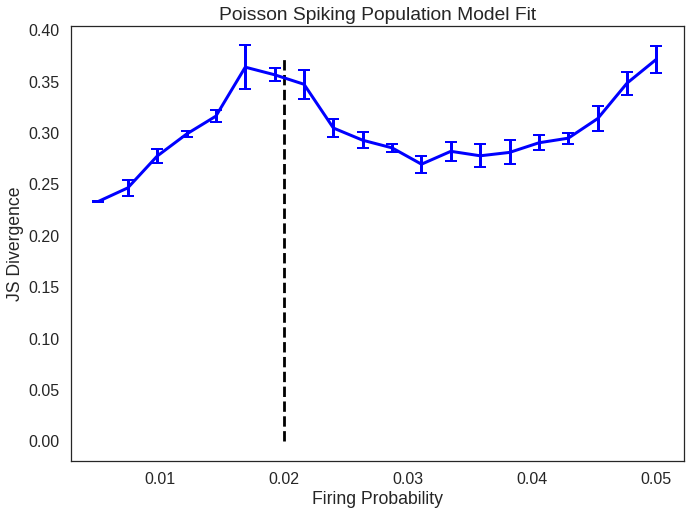

In [91]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, JS, yerr=JSerr, linewidth=3, capsize=6, capthick=2, fmt='b')
#plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(JS), 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('JS Divergence')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

In [105]:
# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


est_save = []
ntrials = 1
X = np.linspace(0.005, 0.05, 20)

beta = -5

for t in range(ntrials):
    print(t)
    KL=[]
    JS = []
    KLerr = []
    JSerr = []
    for x in X:
        print(x)
        (m, stderr) = loss_new_KLmatlog(x, beta)
        KL.append(m)

        KLerr.append(stderr)
        
    
    index_min = np.argmin(KL)
    est_save.append(X[index_min])

0
0.005
error2
error2
error2
error2
error2
0.00736842105263
error2
error2
error2
error2
0.00973684210526
0.0121052631579
error2
0.0144736842105
0.0168421052632
0.0192105263158
0.0215789473684


/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:838: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


0.0239473684211
0.0263157894737
0.0286842105263
0.0310526315789
0.0334210526316
0.0357894736842
0.0381578947368
0.0405263157895
0.0428947368421
0.0452631578947
0.0476315789474
logm result may be inaccurate, approximate err = 2.68286349598064e-13
0.05


/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


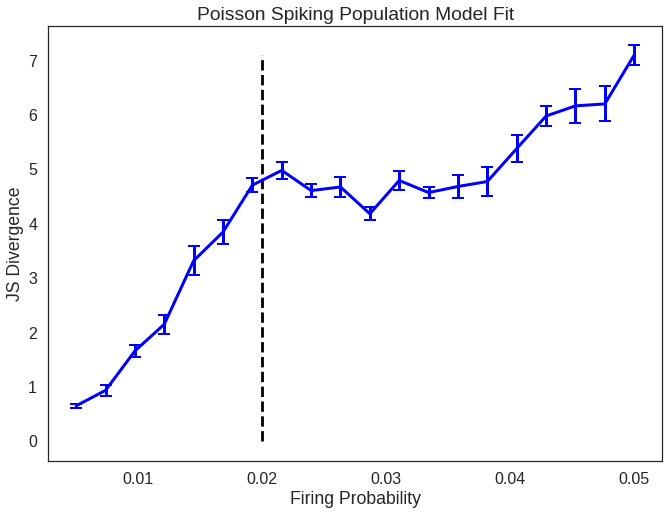

In [106]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
#plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(KL), 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('JS Divergence')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

In [23]:
# Compute SCG for each sample
# Old JS divergence
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


est_save = []
ntrials = 1
X = np.linspace(0.005, 0.08, 50)

beta = -0.15

for t in range(ntrials):
    print(t)
    KL=[]
    JS = []
    KLerr = []
    JSerr = []
    for x in tqdm.tqdm(X):
        (m, mjs, stderr, stderrjs) = loss_old_JS(x, beta)
        KL.append(m)
        JS.append(mjs)
        KLerr.append(stderr)
        JSerr.append(stderrjs)
        
    
    index_min = np.argmin(KL)
    est_save.append(X[index_min])

  0%|          | 0/50 [00:00<?, ?it/s]

0
error2
error2
error2
error2
error2
error2
error2
error2
error2


  2%|▏         | 1/50 [00:00<00:11,  4.38it/s]

error2
error2
error2
error2
error2


  4%|▍         | 2/50 [00:00<00:11,  4.08it/s]

error2
error2
error2
error2


  6%|▌         | 3/50 [00:00<00:12,  3.72it/s]

error2
error2
error2


  8%|▊         | 4/50 [00:01<00:12,  3.68it/s]

error2
error2
error2


 10%|█         | 5/50 [00:01<00:12,  3.69it/s]

error2
error2


 12%|█▏        | 6/50 [00:01<00:11,  3.71it/s]

error2
error2


100%|██████████| 50/50 [00:57<00:00,  2.16s/it]


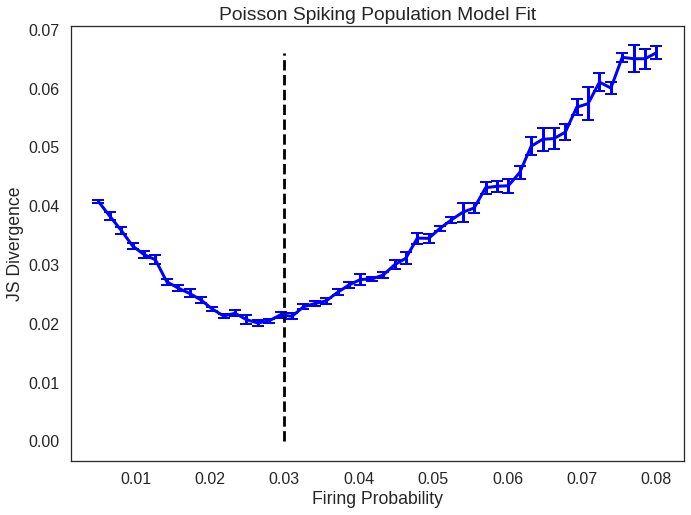

In [24]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, JS, yerr=JSerr, linewidth=3, capsize=6, capthick=2, fmt='b')
#plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(JS), 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('JS Divergence')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

In [41]:
testA = sc.simplicialChainGroups([(1,2,3)])
testB = sc.simplicialChainGroups([(1,2), (2,3), (1,3)])
LA = sc.compute_laplacian(testA, 1)
LB = sc.compute_laplacian(testB, 1)
(LB, LA) = sc.reconcile_laplacians(LB, LA)
Da = sc.densityMatrix(LA, -0.15)
Db = sc.densityMatrix(LB, -0.15)
sc.KLdivergence(Da, Db)

error2


0.033875082830867265

In [2]:
# Do Model Fitting with C code
dim = 1
nsamples2 = 25

def binmat_to_scg_C_old(sptrain):
    
    # turn a binmat to a C scg
    scg = pyslsa.SCG()
    msimps = sc.binarytomaxsimplex(binMat=sptrain, rDup=True)
    for msimp in msimps:
        t = pyslsa.Simplex()
        for vert in msimp:
            t.add_vertex(vert)
        scg.add_max_simplex(t)
    return scg

def binmat_to_scg_C(sptrain):
    msimps = sc.binarytomaxsimplex(sptrain, True)
    return pyslsa.build_SCG(msimps)
    
def precompute_test_scg(tests):
    Emodels = []
    for ind in range(nsamples2):
        Emodels.append(binmat_to_scg_C(tests[:, :, ind]))
    
    return Emodels


def loss_C(a, beta):
    # take a probabilities,
    # generate random configurations, 
    # measure KL divergence to data, 
    # report loss
    
    # Declare variables
    KLsave = []
    JSsave = []
    probs = (a*np.ones((ncells, 1)))

    # Generate new spike trains
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    #Emodels = precompute_test_scg(binMatsamples)
    
    # Compute simplicial complex 
    SCGs = []
    for ind in range(nsamples2):
        maxsimps = sc.binarytomaxsimplex(binMatsamples[:, :, ind], rDup=True)
        # Compute SCG for test spike trains
        #Emodel = Emodels[ind]
        Emodel = pyslsa.build_SCG(maxsimps)

        # Compute KL divergence for this test spike train and store it. 
        #%time div = pyslsa.KL(Etarget, Emodel, dim, beta)
        div = pyslsa.KL(Etarget, Emodel, dim, beta)
        KLsave.append(div)
    
    # Compute mean and stderr over all the test spike trains
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

def loss_C_precomp(ind, beta):
    KLsave=[]
    Emodels = Emodels_p[ind]
    for ind2 in range(nsamples2):
        
        # Compute SCG for test spike trains
        Emodel = Emodels[ind2]

        # Compute KL divergence for this test spike train and store it. 
        div = pyslsa.KL(Etarget, Emodel, dim, beta)
        KLsave.append(div)
    
    # Compute mean and stderr over all the test spike trains
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

def KL_python(Etarg, Emodel, d, beta):


    #Ddata = sc.boundaryOperatorMatrix(Edata, d)
    #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
    Lsamp = sc.compute_laplacian(Emodel, d)
    Ldata = sc.compute_laplacian(Etarg, d)
    if (np.size(Lsamp) > np.size(Ldata)):
        (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
    else:
        (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
    #rsamp = sc.densityMatrix(Lsamp, beta)

    #rdata = sc.densityMatrix(Ldata, beta)
    #print(Ldata)
    #print(rsamp)
    #print(rdata)

    #KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
    #JSsave.append(sc.JSdivergence(rdata, rsamp))
    return sc.KLdivergence_lap(Ldata, Lsamp, beta)

In [3]:
# Generate binary matrix with given probabilities for each "cell"
ncells = 20
nwin = 1000
a = 0.03
probs = (a*np.ones((ncells, 1)))
nsamples = 2
samples = np.random.rand(ncells, nwin, nsamples)
probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
probmat = np.tile(probmat, (1, 1, nsamples))
binMatsamples = np.greater(probmat, samples).astype(int)

In [4]:
# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    E = binmat_to_scg_C(binMatsamples[:, :, ind])
    SCGs.append(E)
Etarget = SCGs[0]
Etest = SCGs[1]

SCGs_old = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs_old.append(E)
Etarget_old = SCGs_old[0]
Etest_old = SCGs_old[1]

In [5]:
# Precompute test matrices
Emodels_p = []
for p in X:
    probs = (p*np.ones((ncells, 1)))

    # Generate new spike trains
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    Emodels = precompute_test_scg(binMatsamples)
    Emodels_p.append(Emodels)

NameError: name 'X' is not defined

In [5]:
est_save = []
ntrials = 1
X = np.linspace(0.01, 0.1, 50)

beta = 0.15

for t in range(ntrials):
    #print(t)
    KL=[]
    JS = []
    KLerr = []
    JSerr = []
    for i, x in tqdm.tqdm(enumerate(X)):
        #print(x)
        (m, stderr) = loss_C(x, beta)
        KL.append(m)
        KLerr.append(stderr)
        
    
    index_min = np.argmin(KL)
    est_save.append(X[index_min])

7it [00:18,  2.69s/it]

KeyboardInterrupt: 

In [9]:
ncells = 20
def loss_C(a, beta, Etarget):
    # take a probabilities,
    # generate random configurations, 
    # measure KL divergence to data, 
    # report loss
    
    # Declare variables
    KLsave = []
    JSsave = []
    probs = (a*np.ones((ncells, 1)))

    # Generate new spike trains
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    #Emodels = precompute_test_scg(binMatsamples)
    
    # Compute simplicial complex 
    SCGs = []
    for ind in range(nsamples2):
        maxsimps = sc.binarytomaxsimplex(binMatsamples[:, :, ind], rDup=True)
        # Compute SCG for test spike trains
        #Emodel = Emodels[ind]
        Emodel = pyslsa.build_SCG(maxsimps)

        # Compute KL divergence for this test spike train and store it. 
        #%time div = pyslsa.KL(Etarget, Emodel, dim, beta)
        div = pyslsa.cuKL(Etarget, Emodel, dim, beta)
        KLsave.append(div)
    
    # Compute mean and stderr over all the test spike trains
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)
def run_simulation(alphas):
    KLS = []
    for alpha in alphas:
        # Generate binary matrix with given probabilities for each "cell"
        ncells = 100
        nwin = 1000
        a = alpha
        print(a)
        probs = (a*np.ones((ncells, 1)))
        nsamples = 2
        samples = np.random.rand(ncells, nwin, nsamples)
        probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
        probmat = np.tile(probmat, (1, 1, nsamples))
        binMatsamples = np.greater(probmat, samples).astype(int)
        # Compute SCG for each sample
        SCGs = []
        for ind in range(nsamples):
            E = binmat_to_scg_C(binMatsamples[:, :, ind])
            SCGs.append(E)
        Etarget = SCGs[0]
        Etest = SCGs[1]

        SCGs_old = []
        for ind in range(nsamples):
            msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
            E = sc.simplicialChainGroups(msimps)
            SCGs_old.append(E)
        Etarget_old = SCGs_old[0]
        Etest_old = SCGs_old[1]
        
        est_save = []
        ntrials = 1
        X = np.linspace(0.001, 0.1, 25)
        beta = 0.2
        #print(t)
        KL=[]
        JS = []
        KLerr = []
        JSerr = []
        for i, x in tqdm.tqdm(enumerate(X)):
            #print(x)
            (m, stderr) = loss_C(x, beta, Etarget)
            KL.append(m)
            KLerr.append(stderr)
        KLS.append((KL, KLerr))
        
    return KLS, X

In [7]:
import time
np.random.seed(int(time.time()))

In [10]:
alphas = [0.01, 0.02, 0.03, 0.04]
alphas = [0.01, 0.03]
kls, X = run_simulation(alphas)



0it [00:00, ?it/s]

0.01



1it [00:04,  4.33s/it]
2it [00:08,  4.32s/it]
Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/brad/.conda/envs/neuraltda-4/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/brad/.conda/envs/neuraltda-4/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

25it [02:06,  5.05s/it]


0.03


0it [00:00, ?it/s]

KeyboardInterrupt: 

In [99]:
kls[0]

([0.07779747869110455,
  0.07150547624174665,
  0.05979542225704089,
  0.057143416953909,
  0.0417097452451142,
  0.0299475616935268,
  0.02569723988922374,
  0.017930821677494074,
  0.012278120170392124,
  0.009207749989478767,
  0.004568294352941007,
  0.007064364381863069,
  0.0060844400117479195,
  0.008299831143159245,
  0.014832694565706617,
  0.022196923810263374,
  0.02704745443496746,
  0.03694710137797365,
  0.050877352727047284,
  0.06646087288920824,
  0.0742789296736693,
  0.09050054875910994,
  0.12187442478594264,
  0.13385711521926932,
  0.15768788754011523,
  0.17428859417763345,
  0.181517168497717,
  0.23044075174487952,
  0.26353474935173726,
  0.2769327767523969,
  0.30121023559155935,
  0.32076921973760814,
  0.3117262772550587,
  0.35721378691116235,
  0.3753156363420837,
  0.4065484102241112,
  0.4128610472992201,
  0.4319343749183808,
  0.4358950481201786,
  0.4752478912442525,
  0.475729255803229,
  0.4969872375167628,
  0.5164008069164587,
  0.517156789608261

2
50
50
50
50


(0.0, 0.05)

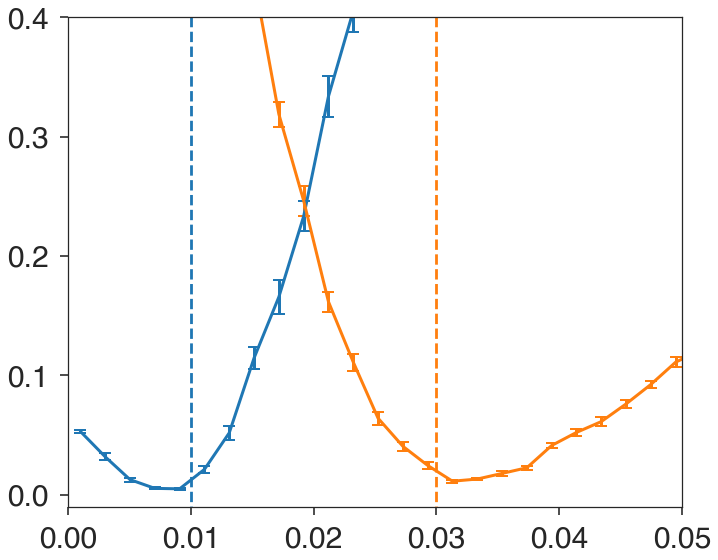

In [6]:

print(len(kls))
#sns.set_style('white')
fig = plt.figure(figsize=(11,9))
ax = fig.add_subplot(111)
for ind, (KL, KLerr) in enumerate(kls):
    print(len(KL))
    print(len(KL))
    p, _, _ = ax.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2)
    ax.plot([alphas[ind], alphas[ind]], [-2, 2], color=p.get_color(), linestyle='--')
    
ax.tick_params(which='both', labelsize=30, length=8)
for tick in ax.get_xticklabels():
    tick.set_fontname('helvetica')
for tick in ax.get_yticklabels():
    tick.set_fontname('helvetica')
    
ax.set_ylim(-0.01, 0.4)
ax.set_xlim(0.0, 0.05)

In [117]:
time.time()

1517617261.1918032

Text(0.5,1,'Poisson Spiking Population Model Fit')

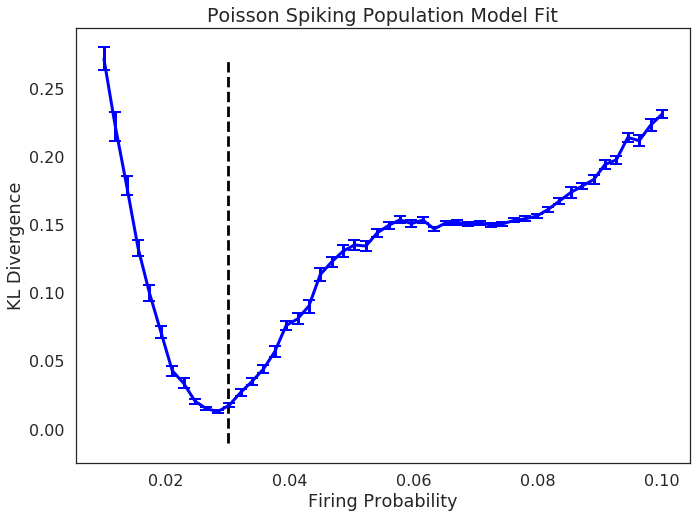

In [43]:
sns.set_style('white')
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(111)
for KL, KLerr in kls:
    ax.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')

plt.plot(a*np.ones((20, 1)), np.linspace(-0.010, np.amax(KL), 20), 'k--')
#plt.xlim([0, 0.04])
#plt.ylim(-0.01, 0.4)
plt.xlabel('Firing Probability')
plt.ylabel('KL Divergence')
plt.title('Poisson Spiking Population Model Fit')

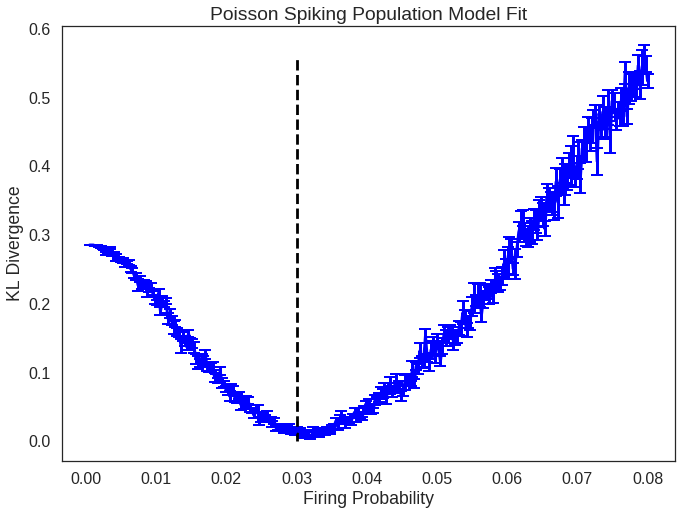

In [8]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')

plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(KL), 20), 'k--')
#plt.xlim([0, 0.04])
#plt.ylim(0, 0.75)
plt.xlabel('Firing Probability')
plt.ylabel('KL Divergence')
plt.title('Poisson Spiking Population Model Fit')

In [22]:
%prun pyslsa.KL(Etarget, Etest, 1, -0.15)

In [14]:
%time KL_python(Etarget_old, Etest_old, 1, -0.15)

CPU times: user 260 ms, sys: 8 ms, total: 268 ms
Wall time: 80.4 ms


0.010594964493285938

In [9]:
print(sc.compute_laplacian(Etarget_old, 1).shape)

(190, 190)


In [30]:
print(Etarget)

In [6]:
pyslsa.build_SCG([(1,2,3), (4,5,6,7), (1,2), (1,5,7)]).print()

In [9]:
msimps = sc.binarytomaxsimplex(binMatsamples[:, :, 0], rDup=True)
%time pyslsa.build_SCG(msimps)

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 23 ms


In [11]:
%time sc.simplicialChainGroups(msimps)

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 31.2 ms


[[()],
 [(0,),
  (1,),
  (2,),
  (3,),
  (4,),
  (5,),
  (6,),
  (7,),
  (8,),
  (9,),
  (10,),
  (11,),
  (12,),
  (13,),
  (14,),
  (15,),
  (16,),
  (17,),
  (18,),
  (19,)],
 [(0, 1),
  (0, 2),
  (0, 3),
  (0, 4),
  (0, 5),
  (0, 6),
  (0, 7),
  (0, 8),
  (0, 9),
  (0, 10),
  (0, 11),
  (0, 12),
  (0, 13),
  (0, 14),
  (0, 15),
  (0, 16),
  (0, 17),
  (0, 18),
  (0, 19),
  (1, 2),
  (1, 3),
  (1, 4),
  (1, 5),
  (1, 6),
  (1, 7),
  (1, 8),
  (1, 9),
  (1, 10),
  (1, 11),
  (1, 12),
  (1, 13),
  (1, 14),
  (1, 15),
  (1, 16),
  (1, 17),
  (1, 18),
  (1, 19),
  (2, 3),
  (2, 4),
  (2, 5),
  (2, 6),
  (2, 7),
  (2, 8),
  (2, 9),
  (2, 10),
  (2, 11),
  (2, 12),
  (2, 13),
  (2, 14),
  (2, 15),
  (2, 16),
  (2, 17),
  (2, 18),
  (2, 19),
  (3, 4),
  (3, 5),
  (3, 6),
  (3, 7),
  (3, 8),
  (3, 9),
  (3, 10),
  (3, 11),
  (3, 12),
  (3, 13),
  (3, 14),
  (3, 15),
  (3, 16),
  (3, 17),
  (3, 18),
  (3, 19),
  (4, 5),
  (4, 6),
  (4, 7),
  (4, 8),
  (4, 9),
  (4, 10),
  (4, 11),
  (4, 12),

In [4]:
msimps

NameError: name 'msimps' is not defined